## Matching Unstructured Text Data With Structured Data using Rule based Weighted Sum Decision Model

#### sample_to_word.csv contains the medical record word OCR sourced from the sample_medical_image.tif
medical image original source: https://www.ahrq.gov/ncepcr/tools/pf-handbook/mod8-app-b-monica-latte.html

Unstructured Data: sample_medical_image.tif is converted into word based data in sample_to_word.csv file

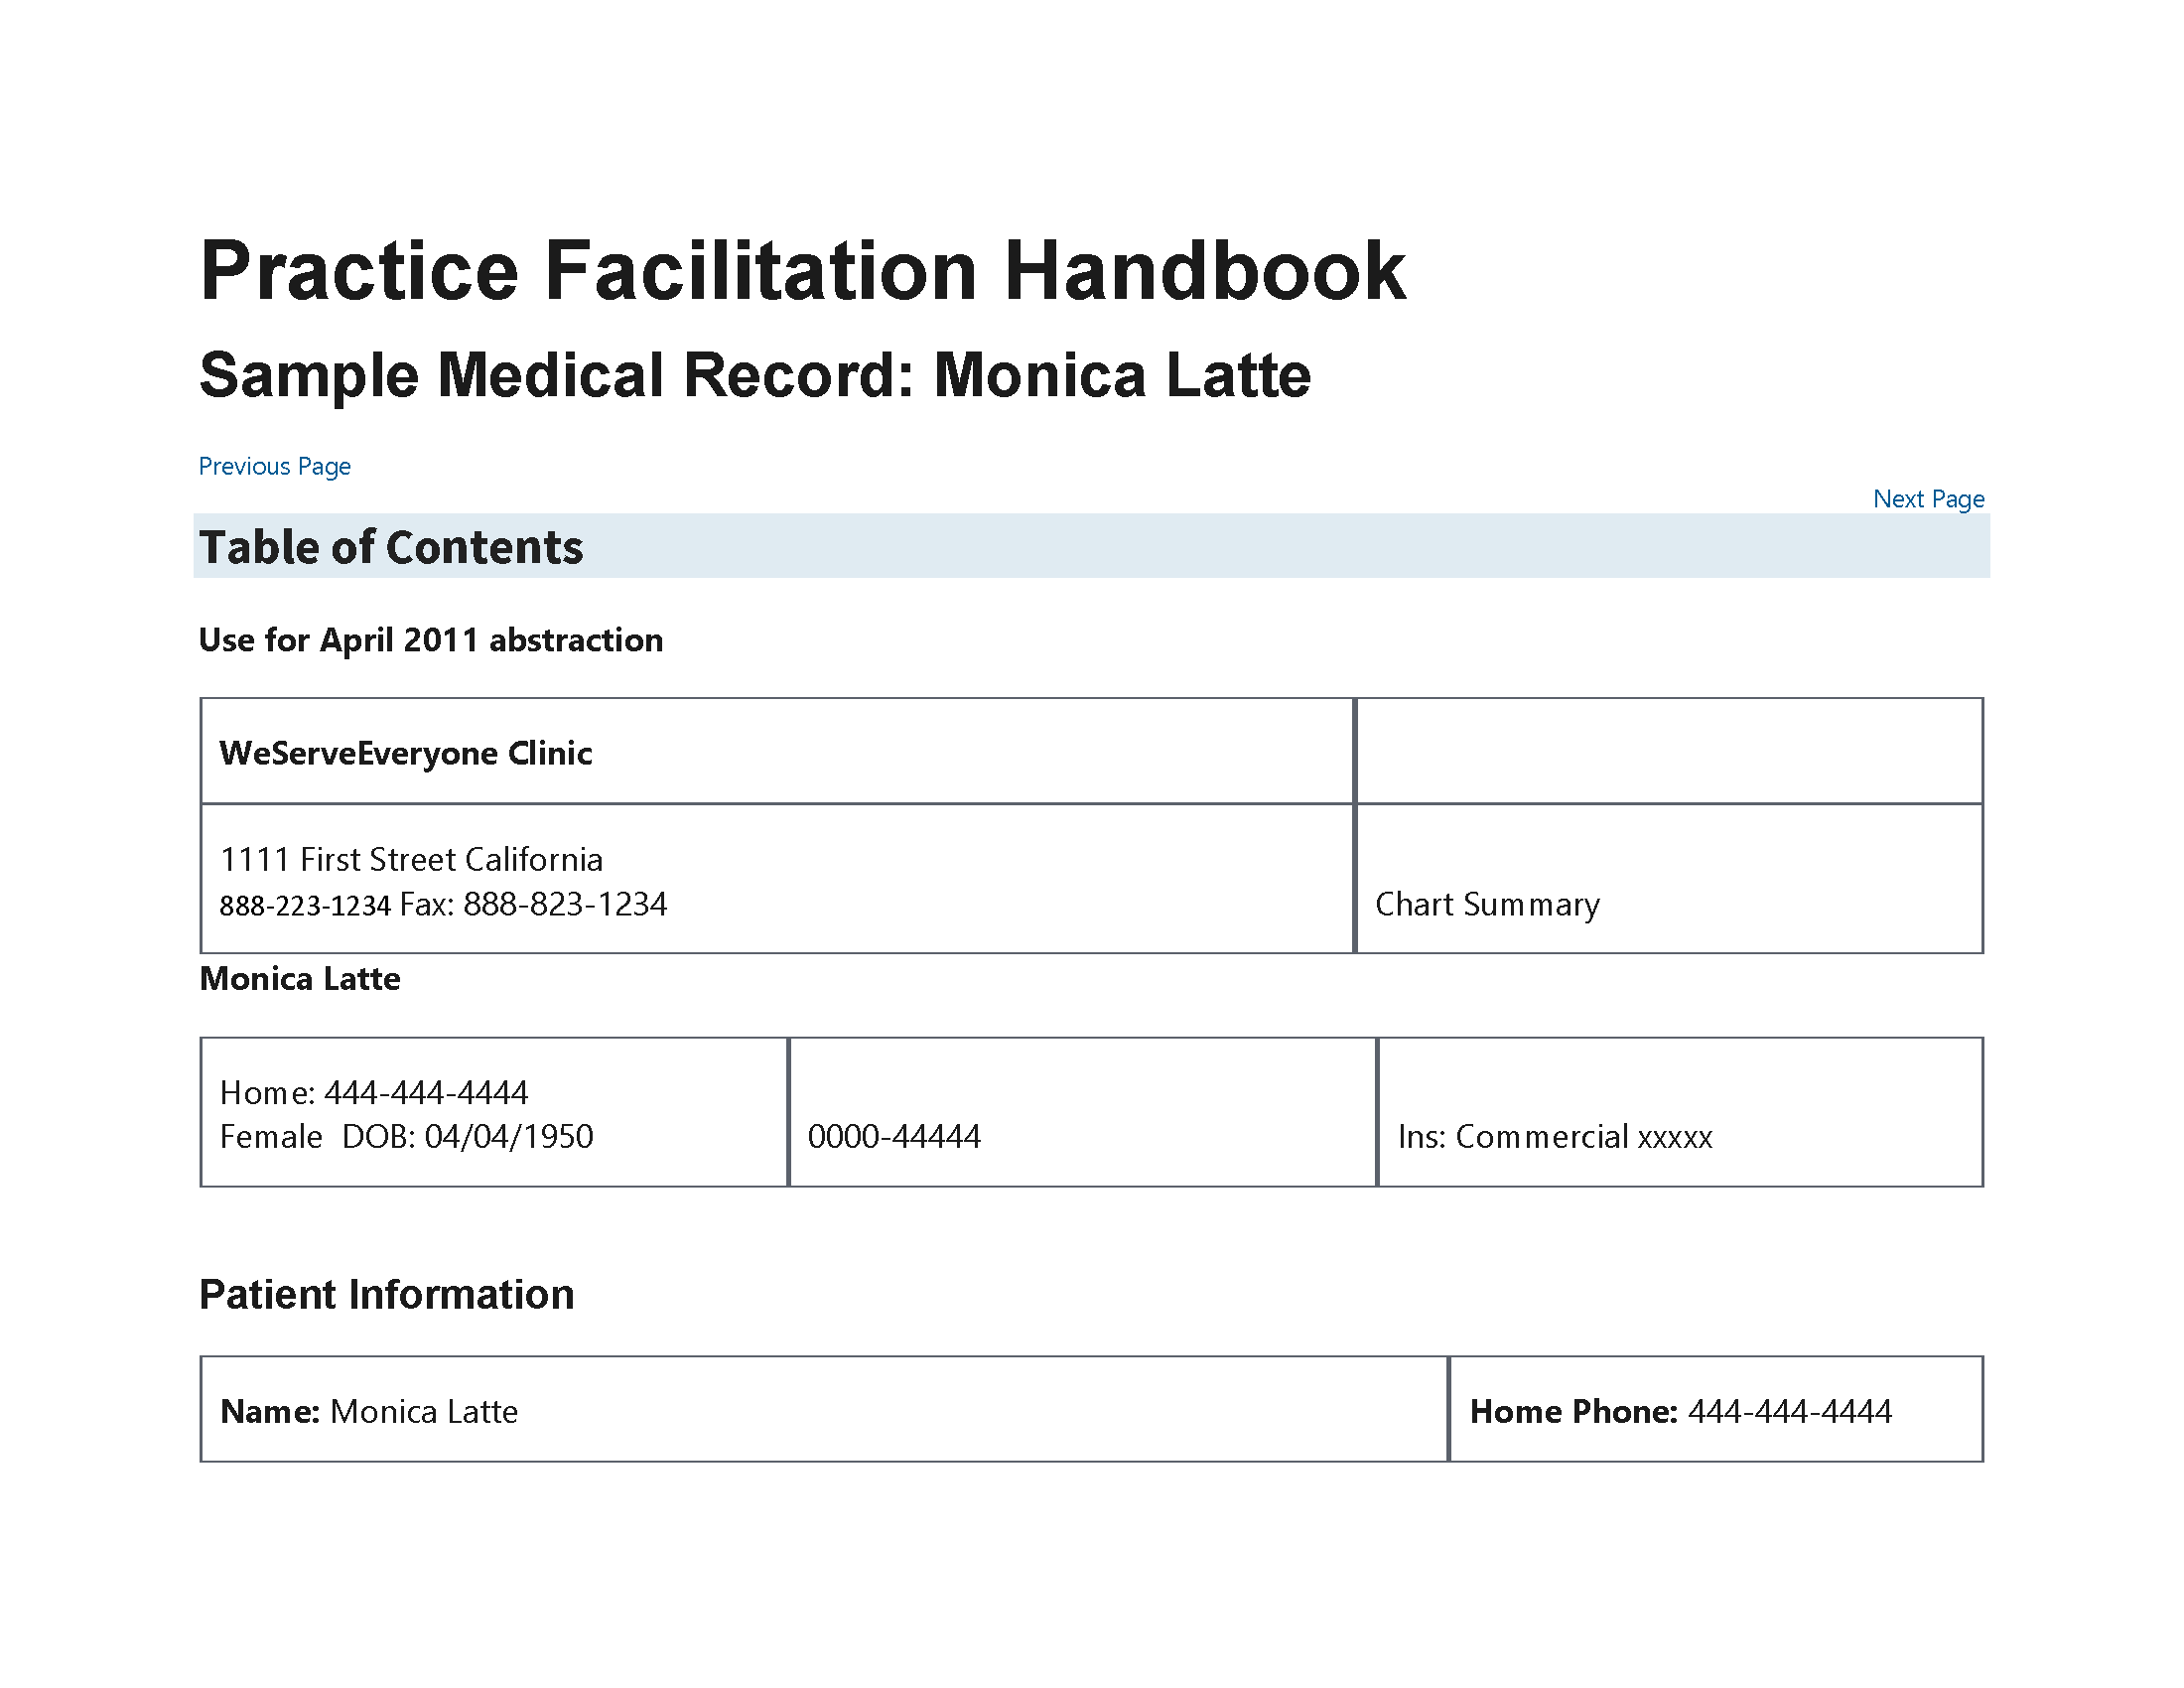

In [1]:
from PIL import Image
Image.open('sample_medical_image.tif')

In [11]:
# WordId: a unique identifier for word
# PageNumber: page number on sample medical record
# X,Y indicated the word co-ordinate
# Confidence: OCR quality measure score
# Value: word token
import pandas as pd
md_word = pd.read_csv('sample_to_words.csv')
md_word.head()

,MyFile,WordId,PageNumber,X,Y,Confidence,Value
0,sample.tif,1,1,206,241,94,Practice
1,sample.tif,2,1,553,241,95,Facilitation
2,sample.tif,3,1,1016,241,94,Handbook
3,sample.tif,4,1,202,353,95,Sample
4,sample.tif,5,1,444,354,94,Medical


In [12]:
md_word.describe().T[['count','mean','std','min','max']]

,count,mean,std,min,max
WordId,788.0,394.500000,227.620298,1.0,788.0
PageNumber,788.0,5.148477,2.434303,1.0,11.0
X,788.0,657.191624,446.397100,200.0,1948.0
Y,788.0,825.837563,395.532262,209.0,1458.0
Confidence,788.0,93.314721,7.084707,16.0,97.0


In [13]:
print('The PageNumber with word count is below:')
print(md_word['PageNumber'].value_counts().sort_index())
md_word['PageNumber'].plot.hist();

The PageNumber with word count is below:
1      50
2      64
3      84
4     112
5     191
6      85
7      54
8      58
9      46
10     26
11     18
Name: PageNumber, dtype: int64


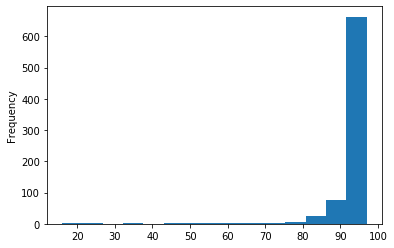

In [14]:
md_word['Confidence'].plot.hist(bins=15);

In [56]:
#Display structured data
registry = pd.read_csv('sample_med_registry.csv')
registry.head()

,record_id,pat_name,pat_dob,prov_name,prov_phone,prov_fax,practice,begin_dos,end_dos
0,M1,Monica Latte,4/4/1950,Carl Savem,(888)223-1234,(888)-823-1234,WeServeEveryone Clinic,1/1/2010,12/31/2011
1,M2,Monica Latte,4/4/1950,Peter Zhou,(888)-555-4466,(888)-888-0000,WeServeEveryone Clinic,1/1/2010,12/31/2011
2,M3,James Smith,2/2/2000,Carl Savem,(888)223-1234,(888)-823-1234,WeServeEveryone Clinic,1/1/2010,12/31/2011


In [57]:

#A structured medical record registry contains the meta data for patient, provider and service dates

In [58]:
#Rule1: match between pat_name and words, find the confidence 
registry1=pd.DataFrame(registry['pat_name'].str.split(' ').tolist(), index=registry['record_id']).stack()
registry1=registry1.reset_index([0,'record_id'])
#rename the splited name into 'Value' column for join
registry1.columns =['record_id','p_name'] 
registry1

,record_id,p_name
0,M1,Monica
1,M1,Latte
2,M2,Monica
3,M2,Latte
4,M3,James
5,M3,Smith


In [59]:
#Join p_name with word Value 
words = md_word[['PageNumber','Value','Confidence']]
registry2 = words.merge(registry1,left_on='Value', right_on='p_name', how='inner')
#pick up the maximum confidence if same page has multiple name instances matched 
registry3 = registry2.groupby(['record_id','PageNumber','p_name']).max().reset_index() 
#apply the product rule P=P1*P2 for compound probability 
registry3 = registry3.groupby(['record_id','PageNumber']).prod().reset_index()\
            [['record_id','PageNumber','Confidence']]
registry3['Pat_name_Confidence'] = registry3.apply(lambda x: x['Confidence']/100, axis = 1) 
registry_pat = registry3[['record_id','PageNumber','Pat_name_Confidence']]\
                .groupby(['record_id']).max().reset_index()\
                [['record_id','Pat_name_Confidence']]
registry_pat

,record_id,Pat_name_Confidence
0,M1,92.16
1,M2,92.16


In [64]:
registry1=pd.DataFrame(registry['practice'].str.split(' ').tolist(), index=registry['record_id']).stack()

In [63]:
#Rule2: match between prov_name and words, find the confidence 
registry1=pd.DataFrame(registry['prov_name'].str.split(' ').tolist(), index=registry['record_id']).stack()
registry1=registry1.reset_index([0,'record_id'])
#rename the splited name into 'Value' column for join
registry1.columns =['record_id','prov_name'] 
#Join p_name with word Value 
registry2=words.merge(registry1,left_on='Value', right_on='prov_name', how='inner')
#pick up the maximum confidence if same page has multiple prov name instances matched 
registry2 = registry2.groupby(['record_id','PageNumber','prov_name']).max().reset_index() 
#apply the product rule P=P1*P2 for compound probability 
registry3 = registry2.groupby(['record_id','PageNumber']).prod().reset_index()
registry3 = registry3[['record_id','PageNumber','Confidence']]
registry3['Prov_name_Confidence'] =  registry3.apply(lambda x: x['Confidence']/100, axis = 1) 
registry_prov = registry3[['record_id','PageNumber','Prov_name_Confidence']] 
registry_prov = registry_prov.groupby(['record_id']).max().reset_index()
registry_prov = registry_prov[['record_id','Prov_name_Confidence']]
registry_prov

,record_id,Prov_name_Confidence
0,M1,84.64
1,M2,91.20
2,M3,84.64


In [65]:
#Rule3: match practice facility
registry1=pd.DataFrame(registry['practice'].str.split(' ').tolist(), index=registry['record_id']).stack()
registry1=registry1.reset_index([0,'record_id'])
#rename the splited name into 'Value' column for join
registry1.columns =['record_id','pract_facility'] 
#Join pract_facility with word Value 
registry2=words.merge(registry1,left_on='Value', right_on='pract_facility', how='inner')
#pick up the maximum confidence if same page has multiple prov name instances matched 
registry2 = registry2.groupby(['record_id','PageNumber','pract_facility']).max().reset_index() 
#apply the product rule P=P1*P2 for compound probability 
registry3 = registry2.groupby(['record_id','PageNumber']).prod().reset_index()
registry3 = registry3[['record_id','PageNumber','Confidence']]
registry3['Practice_Confidence'] =  registry3.apply(lambda x: x['Confidence']/100, axis = 1) 
registry_practice = registry3[['record_id','PageNumber','Practice_Confidence']] 
registry_practice = registry_practice.groupby(['record_id']).max().reset_index()
registry_practice = registry_practice[['record_id','Practice_Confidence']]
registry_practice

,record_id,Practice_Confidence
0,M1,92.15
1,M2,92.15
2,M3,92.15


In [67]:
#Rule: match phone number
registry['prov_phone']= registry['prov_phone'].str.replace(r'[^0-9]\s?',r'',regex=True)
registry['prov_fax']= registry['prov_fax'].str.replace(r'[^0-9]\s?',r'',regex=True)
registry1=registry[['record_id','prov_phone','prov_fax']]
words['Value'] = words['Value'].str.replace(r'[^0-9a-zA-Z]\s?',r'',regex=True)
registry2 = words.merge(registry1, left_on='Value', right_on='prov_phone', how='inner')
registry2 = registry2.groupby(['PageNumber','record_id']).max().reset_index()
registry3 = registry2.groupby(['record_id']).max().reset_index()
registry3['phone_confidence'] = registry3['Confidence']
registry_phone=registry3[['record_id','phone_confidence']]
registry_phone

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,record_id,phone_confidence
0,M1,90
1,M3,90


In [24]:
#Rule 5: match fax number
registry2 = words.merge(registry1, left_on='Value', right_on='prov_fax', how='inner')
registry2 = registry2.groupby(['PageNumber','record_id']).max().reset_index()
registry3 = registry2.groupby(['record_id']).max().reset_index()
registry3['fax_confidence'] = registry3['Confidence']
registry_fax=registry3[['record_id','fax_confidence']]
registry_fax

,record_id,fax_confidence
0,M1,95
1,M3,95


In [49]:
#Rule: match pat DOB
words = md_word[['PageNumber','Confidence','Value']]
#words with date format
words =words[words['Value'].str.contains(r'(^\d{1,2}[-/]\d{1,2}[-/]\d{4})', regex= True)]
words['dt'] =pd.to_datetime(words['Value'])
words = words[['PageNumber','Confidence','dt']]
registry['pat_dob']=pd.to_datetime(registry['pat_dob'])
registry = registry[['record_id','pat_dob']]
registry2 = words.merge(registry, left_on='dt', right_on='pat_dob', how='inner')
registry2 = registry2.groupby(['record_id']).max().reset_index()
registry2['pat_dob_confidence'] = registry2['Confidence']
registry_dob=registry2[['record_id','pat_dob_confidence']]
registry_dob

,record_id,pat_dob_confidence
0,M1,96
1,M2,96


In [69]:
# Weight Factor Table
d = {'match_pat_name': [0.2], 'match_pat_dob': [0.2], 'match_prov_name': [0.24], \
     'match_prov_phone':[0.12], 'match_prov_fax':[0.12], 'match_practice': [0.12] }
weights = pd.DataFrame(data=d)
weights.T

,0
match_pat_name,0.20
match_pat_dob,0.20
match_prov_name,0.24
match_prov_phone,0.12
match_prov_fax,0.12
match_practice,0.12


In [27]:
registry_confidence = registry[['record_id']]
registry_confidence = registry_confidence.merge(registry_pat, how='left').merge(registry_dob, how='left')\
                .merge(registry_prov, how='left').merge(registry_phone, how='left')\
                .merge(registry_fax, how='left').merge(registry_practice, how='left').fillna(0)
registry_confidence

,record_id,Pat_name_Confidence,pat_dob_confidence,Prov_name_Confidence,phone_confidence,fax_confidence,Practice_Confidence
0,M1,92.16,96.0,84.64,90.0,95.0,92.15
1,M2,92.16,96.0,91.20,0.0,0.0,92.15
2,M3,0.00,0.0,84.64,90.0,95.0,92.15


In [28]:
#Weighted Sum Model 
registry_confidence['weighted_sum'] = registry_confidence['Pat_name_Confidence']* weights.T[0][0]  + \
                       registry_confidence['pat_dob_confidence'] * weights.T[0][1] + \
                       registry_confidence['Prov_name_Confidence'] * weights.T[0][2] + \
                       registry_confidence['phone_confidence'] * weights.T[0][3] + \
                       registry_confidence['fax_confidence'] * weights.T[0][4] + \
                       registry_confidence['Practice_Confidence'] * weights.T[0][5]
                                                 
registry_confidence

,record_id,Pat_name_Confidence,pat_dob_confidence,Prov_name_Confidence,phone_confidence,fax_confidence,Practice_Confidence,weighted_sum
0,M1,92.16,96.0,84.64,90.0,95.0,92.15,91.2036
1,M2,92.16,96.0,91.20,0.0,0.0,92.15,70.5780
2,M3,0.00,0.0,84.64,90.0,95.0,92.15,53.5716
